# Расчет Churn Rate

Генерация датафрейма, расчет метрики, визуализация. 
<p>Контекст: Мы работаем в компании, которая занимается продажей товаров через приложение на смартфоне. Приложение существует на двух платформах: Android и iOS. В компании принято считать метрику оттока с окном в 28 дней.
<p>Источник: https://habr.com/ru/companies/joom/articles/708148/

## 1. Подгрузка библиотек

In [20]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import names
import random
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

## 2. Генерация датафрейма

1. Используя библиотеку names, выгружаем из нее имена (10 тысяч, при этом не обязательно они будут уникальными). Получаем массив имен пользователей.
2. Формируем информацию о таблице: массив названий колонок, пока пустой массив для будущих строк датафрейма
3. Для столбцов, где значения - это определенные категории (название платформы, действие), делаем отдельные массивы.
4. Для простоты предполагаем, что пользователь использует только одну из двух возможных платформ. Формируем словарь вида _пользователь: платформа_. 
5. Делим всех наших юзеров на тех, кто будет встречаться в дата фрейме регулярно, и тех, кто будет встречаться там редко. Пусть регулярных будет 2000 из 10000 имеющихся имен, а нерегулярных - количество остальных (8 тыс)
6. Теперь формируем строки датафрейма. 
- Данные будут за период с 1 декабря 2022 года по 29 мая 2023 года, то есть за полгода (180 дней). Идем циклом по каждой из дат (прибавляя к начальной дате сначала 1 день, потом 2... и т.д. до 180 дней, получаем на выходе последовательные даты в заданном диапазоне. 
- Для каждой даты: возвращаем случайное число из диапазона между 2000 и 3000 - это количество строк, соответсвующих этой дате (количество записей за эту дату о совешении каким-то пользователем некоторого действия из списка действий, заданного выше).
- Также в рамках каждой строчки проверяем дату, которой запись принадлежит, на то, является ли дата выходным днем или будним. Если это выходной - то мы случайным образом выбираем 2000 имен из массивов с именами - регулярными и нерегулярными пользователями с определенным весом, если в будний - то же самое, но уже с другим весом (в данном случае в будни доля регулярных пользователей будет выше, в пропорции 7:1, а в выходные ниже в пропорции к нерегулярным пользователям 4:1).  
- Таким образом на выходе имеем список имен в зависимости от дня недели (будни или выходные) для конкретной даты. Эти имена потенциально могли совершать действие в эту дату (причем распределение этих имен именно такое, что имен регулярных пользователей у нас меньше чем нерегулярных, величина разницы в их пропорции зависит от того, яваляется ли день выходным).

7. В итоге остается заполнить строку, которую мы обрабатываем: рандомно выбираем имя из списка имен, подготовленного на шаге 6, рандомно выбираем тип совершенного действия из массива возможных действий, а также находим платформу, которая соответсвует выбранному пользователю через ранее сформированный словарь вида пользователь:платформа. 
8. Добавляем эту строку в виде массива в массив строк (сформированный на шаге 2).
9. После прохождения таким образом циклом по всем датам и по каждой строке, соответствующей определнной дате - формируем дата фрейм. В таблице data - это массив с нашими строками, колонки - обозначенные ранее колонки из массива их названий. 
10. Дополнительно: переводим даты в итоговом датафрейме в формат datetime для удобства дальнейшего анализа.

In [21]:
# здесь будут храниться все имена пользователей, которые мы будем использовать
# таких имен у нас будет не больше 10000 (они не обязательно окажутся уникальными)

names_list = []
for i in range(10000):
    names_list.append(names.get_full_name())
    
names_list[:10]

['Larry Hernandez',
 'Bessie Davis',
 'Melissa Cook',
 'Stacey Durfee',
 'Ian Worley',
 'Christine Flint',
 'Tabitha Johnson',
 'Julian Crisp',
 'Wendell Kuehn',
 'Andrew Johnson']

In [22]:
# колонки будущей таблицы
columns = ['event_date', 'platform', 'name', 'event_type']

# здесь будут храниться строки для будущего датафрейма
df_values = []

# значения, которые будут подставляться случайным образом
platforms = ['ios', 'android']
events = ['purchase', 'productPreview', 'addToCart', 'productClick', 'search', 'feedbackSent']

In [24]:
# формируем соотвествие имени и платформы пользователя
# (для простоты предполагаем, что каждый пользователь использует только одну из двух возможных платформ)
names_platform_dict = {}
for name in names_list:
    names_platform_dict[name] = random.choice(platforms)
    
names_platform_dict['Larry Hernandez']

'ios'

In [25]:
# формируем массивы юзеров по степени уникальности

regular_users = names_list[:2000]
not_regular_users = names_list[2000:]

In [26]:
# проходимся по всем датам с 1 декабря 2021 по 29 мая 2023
for date_index in range(180):
    date = dt.date(2022, 12, 1) + dt.timedelta(days=date_index)
    
    # сколько строк будут соответствовать одному дню
    rows_number  = random.randrange(2000, 3000) # возвращаем случае целое число из диапазона
    
    for name_index in range(rows_number):
        # здесь мы задаем недельную сезонность: в будни доля регулярных юзеров будет выше
        # 1 декабря 2022 - четверг, прибавляем 2 дня до субботы, считаем субботу и воскресенье - выходными
        # таким образомп вычисляем все дни выходные и будни - назначаем этим дням разные веса частоты встречаний
        if (date_index + 2) % 7 == 0 or (date_index + 3 % 7) == 0:
            list_of_names = random.choices([regular_users, not_regular_users], weights = [4, 1])[0]
        else:
            list_of_names = random.choices([regular_users, not_regular_users], weights = [7, 1])[0]
            
        name = random.choice(list_of_names)
        event_type = random.choice(events)
        platform = names_platform_dict[name]
        
        # добавляем строку в массив всех строк для будущего датафрейма
        df_values.append([date, platform, name, event_type])

In [27]:
events = pd.DataFrame(data = df_values, columns = columns)
events.event_date = pd.to_datetime(events.event_date)
events.head()

,event_date,platform,name,event_type
0,2022-12-01,android,Florence Foley,productPreview
1,2022-12-01,android,Daphne Mann,search
2,2022-12-01,android,Steven Mitchell,purchase
3,2022-12-01,android,Jasmine Underwood,productPreview
4,2022-12-01,android,Dawn Strickland,search


In [28]:
events.shape

(447498, 4)

In [32]:
events.to_csv('events.csv')

## Расчет метрики CR

Для начала оставим только уникальные сочетания name, platform, event_date

In [11]:
events_grouped = (
    events.groupby(['event_date', 'platform', 'name'])
    .agg({'event_type': 'count'})
    .reset_index()
)

events_grouped.columns = ['event_date', 'platform', 'name', 'events_number']
events_grouped

,event_date,platform,name,events_number
0,2022-12-01,android,Ada Collins,1
1,2022-12-01,android,Adam Stafford,2
2,2022-12-01,android,Adele Bobbitt,1
3,2022-12-01,android,Adele Rivers,1
4,2022-12-01,android,Adrian Hamill,1
...,...,...,...,...
296943,2023-05-29,ios,William Swager,3
296944,2023-05-29,ios,William Vincent,2
296945,2023-05-29,ios,William Wilson,1
296946,2023-05-29,ios,Willie Byker,1


Теперь для каждого пользователя найдем дату его следующего события. Также найдем, через сколько дней состоялось его следующее событие:

In [12]:
events_grouped['next_event_date'] = events_grouped.groupby(['name', 'platform'])['event_date'].shift(-1)
events_grouped

,event_date,platform,name,events_number,next_event_date
0,2022-12-01,android,Ada Collins,1,2022-12-03
1,2022-12-01,android,Adam Stafford,2,2022-12-02
2,2022-12-01,android,Adele Bobbitt,1,2022-12-02
3,2022-12-01,android,Adele Rivers,1,2023-01-22
4,2022-12-01,android,Adrian Hamill,1,2022-12-15
...,...,...,...,...,...
296943,2023-05-29,ios,William Swager,3,NaT
296944,2023-05-29,ios,William Vincent,2,NaT
296945,2023-05-29,ios,William Wilson,1,NaT
296946,2023-05-29,ios,Willie Byker,1,NaT


In [13]:
events_grouped['days_till_next_event'] = (
    (events_grouped['next_event_date'] - events_grouped['event_date'])/np.timedelta64(1, 'D')
)
events_grouped

,event_date,platform,name,events_number,next_event_date,days_till_next_event
0,2022-12-01,android,Ada Collins,1,2022-12-03,2.0
1,2022-12-01,android,Adam Stafford,2,2022-12-02,1.0
2,2022-12-01,android,Adele Bobbitt,1,2022-12-02,1.0
3,2022-12-01,android,Adele Rivers,1,2023-01-22,52.0
4,2022-12-01,android,Adrian Hamill,1,2022-12-15,14.0
...,...,...,...,...,...,...
296943,2023-05-29,ios,William Swager,3,NaT,NaN
296944,2023-05-29,ios,William Vincent,2,NaT,NaN
296945,2023-05-29,ios,William Wilson,1,NaT,NaN
296946,2023-05-29,ios,Willie Byker,1,NaT,NaN


Добавим маркер, попал ли пользователь в отток (пользователь, не совершавший никаких  действий в течение 28 дней)

In [14]:
events_grouped['is_churned_int'] = events_grouped['days_till_next_event'].apply(lambda x: 0 if x < 28 else 1)
events_grouped

,event_date,platform,name,events_number,next_event_date,days_till_next_event,is_churned_int
0,2022-12-01,android,Ada Collins,1,2022-12-03,2.0,0
1,2022-12-01,android,Adam Stafford,2,2022-12-02,1.0,0
2,2022-12-01,android,Adele Bobbitt,1,2022-12-02,1.0,0
3,2022-12-01,android,Adele Rivers,1,2023-01-22,52.0,1
4,2022-12-01,android,Adrian Hamill,1,2022-12-15,14.0,0
...,...,...,...,...,...,...,...
296943,2023-05-29,ios,William Swager,3,NaT,NaN,1
296944,2023-05-29,ios,William Vincent,2,NaT,NaN,1
296945,2023-05-29,ios,William Wilson,1,NaT,NaN,1
296946,2023-05-29,ios,Willie Byker,1,NaT,NaN,1


У нас есть все для того, чтобы посчитать метрику Churn Rate. Найдем максимальную дату, с момента которой прошел 28 дней , срежем ненужные строки. После посчитаем для каждой даты кол-во уникальных пользователей (DAU) и число тех, кто попал в отток. Затем рассчитаем долю тех, кто попал в отток, от общего числа.

In [15]:
# макс дата, для которой подсчет метрики можно считать корректным (с момента которой прошло точно прошло 28 дней)
max_relevant_date = events_grouped.event_date.max() - dt.timedelta(days=28)

# убираем нерелевантные даты
# считаем, сколько людей попало в отток
# считаем dau - кол-во уникальных пользователей
churn_rate = (
    events_grouped.query('event_date <= @max_relevant_date')
    .groupby(['event_date'], as_index=False)
    .agg({'is_churned_int': 'sum', 'name': 'nunique'})
)
churn_rate.columns = ['event_date', 'churned', 'dau']

churn_rate

,event_date,churned,dau
0,2022-12-01,96,1697
1,2022-12-02,77,1567
2,2022-12-03,110,1745
3,2022-12-04,98,1590
4,2022-12-05,107,1707
...,...,...,...
147,2023-04-27,101,1720
148,2023-04-28,118,1758
149,2023-04-29,113,1701
150,2023-04-30,114,1804


__Расчитываем метрику__

In [16]:
churn_rate['churn_rate'] = churn_rate.churned / churn_rate.dau
churn_rate['churn_rate_perc'] = churn_rate.churn_rate * 100

churn_rate

,event_date,churned,dau,churn_rate,churn_rate_perc
0,2022-12-01,96,1697,0.056570,5.657042
1,2022-12-02,77,1567,0.049138,4.913848
2,2022-12-03,110,1745,0.063037,6.303725
3,2022-12-04,98,1590,0.061635,6.163522
4,2022-12-05,107,1707,0.062683,6.268307
...,...,...,...,...,...
147,2023-04-27,101,1720,0.058721,5.872093
148,2023-04-28,118,1758,0.067122,6.712173
149,2023-04-29,113,1701,0.066432,6.643151
150,2023-04-30,114,1804,0.063193,6.319290


## Визуализация данных

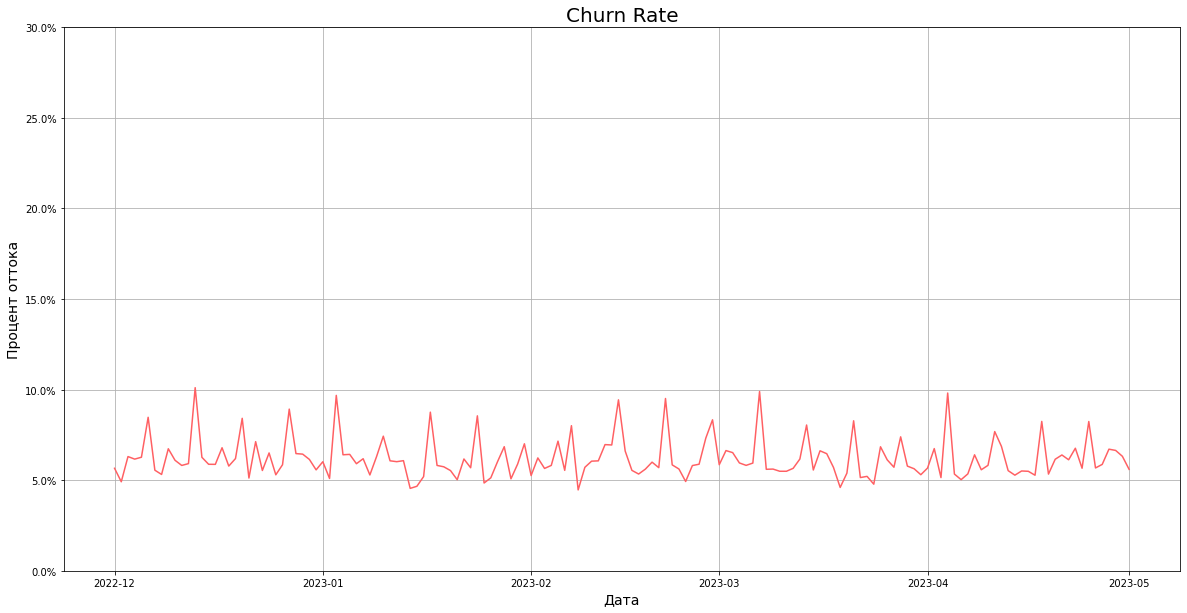

In [17]:
palette = ['#ff6063', '#32b6aa', '#ffcc53']
sns.set_palette(palette)

plt.figure(figsize=(20, 10)) # размер рисунка
plt.grid() # сетка

ax = sns.lineplot(data=churn_rate, y='churn_rate_perc', x='event_date')
ax.set_title('Churn Rate', fontsize = 20)
ax.set_xlabel('Дата', fontsize = 14)
ax.set_ylabel('Процент оттока', fontsize=14)
ax.set(ylim = (0, 30))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

Посчитаем также метрику __отдельно по платформе__

In [18]:
churn_rate_platform = (
    events_grouped.query('event_date <= @max_relevant_date')
    .groupby(['event_date', 'platform'])
    .agg({'is_churned_int': 'sum', 'name': 'nunique'})
)

churn_rate_platform.columns = ['churned_names', 'dau']
churn_rate_platform['churn_rate'] = churn_rate_platform['churned_names'] / churn_rate_platform['dau']
churn_rate_platform['churn_rate_perc'] = churn_rate_platform['churn_rate']*100

churn_rate_platform

churned_names  dau  churn_rate  churn_rate_perc
event_date platform                                                 
2022-12-01 android              43  882    0.048753         4.875283
           ios                  53  815    0.065031         6.503067
2022-12-02 android              37  818    0.045232         4.523227
           ios                  40  749    0.053405         5.340454
2022-12-03 android              55  901    0.061043         6.104329
...                            ...  ...         ...              ...
2023-04-29 ios                  60  842    0.071259         7.125891
2023-04-30 android              60  905    0.066298         6.629834
           ios                  54  899    0.060067         6.006674
2023-05-01 android              40  750    0.053333         5.333333
           ios                  45  768    0.058594         5.859375

[304 rows x 4 columns]

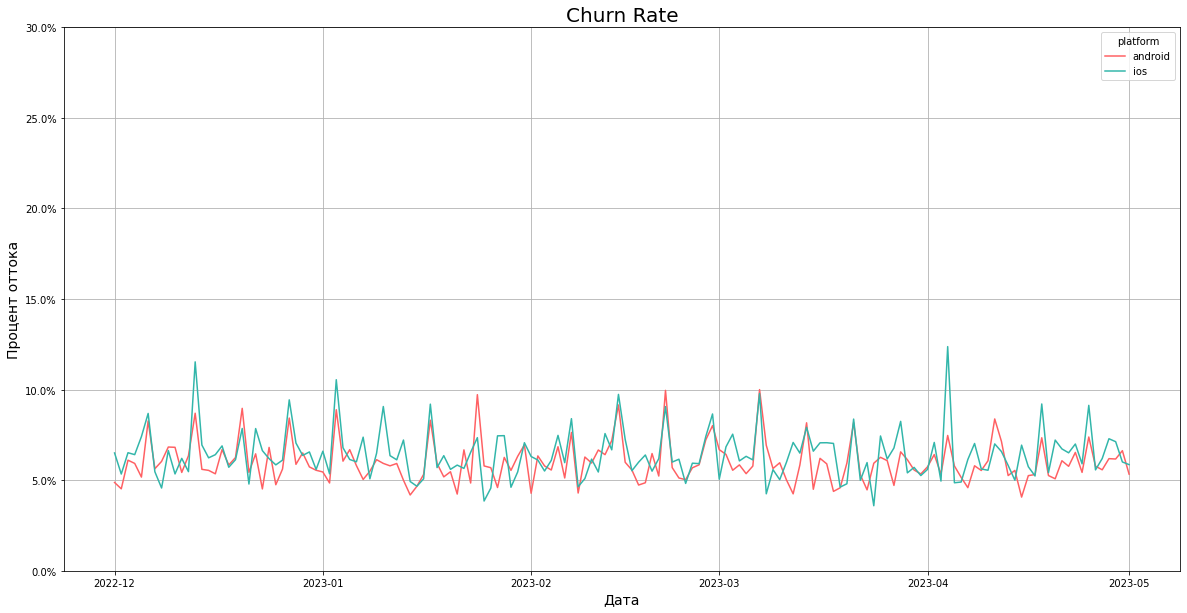

In [19]:
plt.figure(figsize=(20,10))

plt.grid()

ax = sns.lineplot(data=churn_rate_platform, y = 'churn_rate_perc', x = 'event_date', hue = 'platform')
ax.set_title('Churn Rate', fontsize=20)
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Процент оттока', fontsize=14)

ax.set(ylim = (0,30))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

Вне зависимости от платформы отток клиентов ведет себя одинаково и не превышает 12-13%. При этом видна недельная сезонность в данных, отток увеличивается по выходным дням, лояльные и регулярные клиенты покупают чаще в будни.